In [26]:
from argparse import ArgumentParser
import time

import matplotlib.pyplot as plt
import numpy as np
import sympy

from devito import Grid, Eq, Operator, TimeFunction, solve
from devito.logger import log

In [27]:
def before_shut_in(ui, spacing=0.01, a=0.5, timesteps=50, b=0.1, pres = 100):
    nx, ny = ui.shape
    dx2, dy2 = spacing**2, spacing**2
    dt = dx2 * dy2 / (2 * a * (dx2 + dy2))
    # Allocate the grid and set initial condition
    grid = Grid(shape=(nx, ny))
    u = TimeFunction(name='u', grid=grid, time_order=1, space_order=2)
    u.data[0, :] = ui[:]
    # Derive the stencil according to devito conventions
    eqn = Eq(u.dt, a * (u.dx2 + u.dy2) + b * (pres - u))
    stencil = solve(eqn, u.forward)
    
    # bc1: we are bumping water out of the well
    bc1 = [Eq(u[1, nx//2, ny//2], 0)]
    
    x, y = grid.dimensions
    # bc2: Neumann boundary condition
    # create boundary condition
    bc = [Eq(u[1, 0,    y],    u[1, 1,    y])]
    bc+= [Eq(u[1, nx-1, y],    u[1, nx - 2, y])]
    bc+= [Eq(u[1, x, ny-1],    u[1, x, ny - 2])]
    bc+= [Eq(u[1, x,    0],    u[1, x,    1])]
    
    # operator
    op = Operator([Eq(u.forward, stencil)] + bc1 + bc)

    # Execute the generated Devito stencil operator
    tstart = time.time()
    op.apply(u=u, t=timesteps, dt=dt)
    runtime = time.time() - tstart
    log("Devito: Diffusion with dx=%0.4f, dy=%0.4f, executed %d timesteps in %f seconds"
        % (spacing, spacing, timesteps, runtime))
    return u.data[1, :], runtime

In [28]:
# init grid
nx, ny = 100, 100
nt = 260
pres = 100
tm = 0
grid = np.ones((nx, ny)) * pres
data = np.zeros((nx, ny, nt))
grid[nx//2,ny//2] = 0
data[:,:,0] = grid

In [29]:
for iter in range(nt - 1): 
    data[:, :, iter + 1], tm = before_shut_in(data[:,:,iter], timesteps=1)

Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.030382 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.014878 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.014470 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.012897 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.013500 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.013059 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.013535 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.012969 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with d

In [30]:
import matplotlib.pyplot as plt

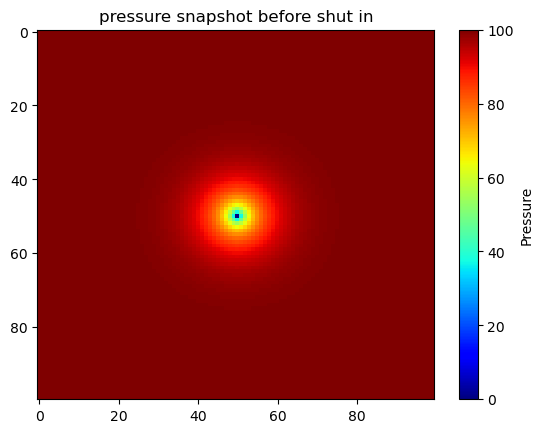

In [31]:
fig = plt.figure()
cax = plt.imshow(data[:,:,-1], aspect='auto', cmap='jet')
cbar = fig.colorbar(cax)
cbar.set_label('Pressure')
plt.title("pressure snapshot before shut in")
plt.show()

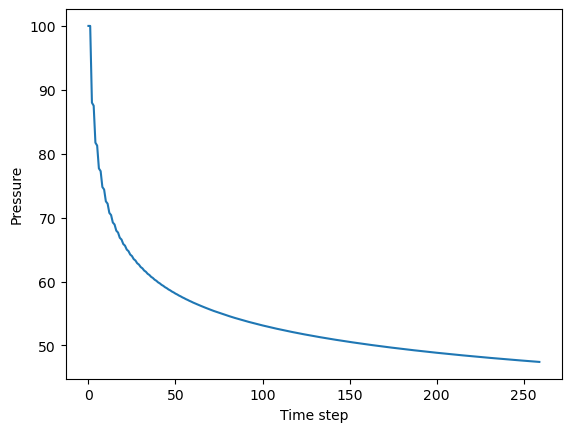

In [32]:
plt.figure()
plt.plot(data[49,49,:])
plt.xlabel('Time step')
plt.ylabel('Pressure')
plt.show()

In [33]:
def aft_shut_in(ui, spacing=0.01, a=0.5, timesteps=50, b=0.1, pres = 100):
    """
    :param ui: The initial condition of the grid as a 2D numpy array.
    :param spacing: The spacing length between grid points. Default value is 0.01.
    :param a: The diffusion coefficient. Default value is 0.5.
    :param timesteps: The number of timesteps to execute the diffusion. Default value is 50.
    :return: A tuple containing two elements: the final state of the grid after timesteps executions and the runtime in seconds.

    """
    nx, ny = ui.shape
    dx2, dy2 = spacing**2, spacing**2
    dt = dx2 * dy2 / (2 * a * (dx2 + dy2))
    # Allocate the grid and set initial condition
    grid = Grid(shape=(nx, ny))
    u = TimeFunction(name='u', grid=grid, time_order=1, space_order=2)
    u.data[0, :] = ui[:]
    # Derive the stencil according to devito conventions
    eqn = Eq(u.dt, a * (u.dx2 + u.dy2) + b * (pres - u))
    stencil = solve(eqn, u.forward)
    
    x, y = grid.dimensions
    # bc: Neumann boundary condition
    # create boundary condition
    bc = [Eq(u[1, 0,    y],    u[1, 1,    y])]
    bc+= [Eq(u[1, nx-1, y],    u[1, nx - 2, y])]
    bc+= [Eq(u[1, x, ny-1],    u[1, x, ny - 2])]
    bc+= [Eq(u[1, x,    0],    u[1, x,    1])]
    
    # operator
    op = Operator([Eq(u.forward, stencil)] + bc)

    # Execute the generated Devito stencil operator
    tstart = time.time()
    op.apply(u=u, t=timesteps, dt=dt)
    runtime = time.time() - tstart
    log("Devito: Diffusion with dx=%0.4f, dy=%0.4f, executed %d timesteps in %f seconds"
        % (spacing, spacing, timesteps, runtime))
    return u.data[1, :], runtime

In [34]:
nt2 = 100
data2 = np.ones((nx, ny, nt2))
for iter in range(nt2):
    if iter == 0: 
        data2[:,:,0], tm = aft_shut_in(data[:,:,-1], timesteps=1)
    else:
        data2[:,:,iter],tm=aft_shut_in(data2[:,:,iter-1], timesteps=1)

Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.015589 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.016102 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.015678 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.015802 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.016388 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.023686 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.015646 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.015051 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with d

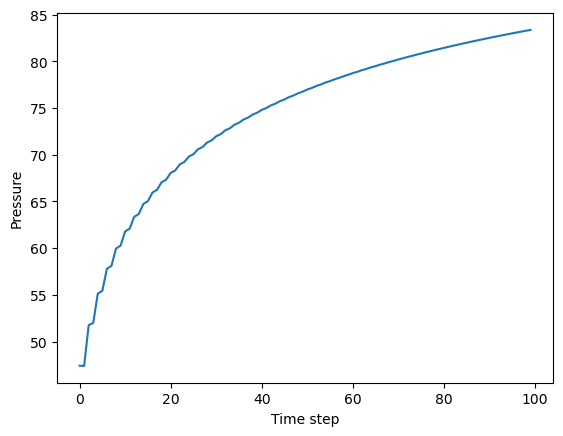

In [35]:
plt.figure()
plt.plot(data2[49,49,:])
plt.xlabel('Time step')
plt.ylabel('Pressure')
plt.show()

In [36]:
result = np.concatenate((data, data2), axis=2)

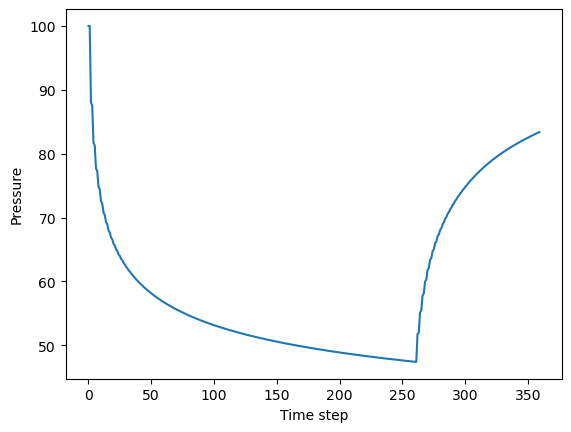

In [37]:
plt.figure()
plt.plot(result[49,49,:])
plt.xlabel('Time step')
plt.ylabel('Pressure')
plt.show()

NameError: name 'eqn' is not defined